In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [15]:
df = pd.read_csv("../data/labelled_data.csv")
df.head()

,Total Volume,Total Fails,Labels
0,1,0,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1


### Classification  

In [16]:
# data

X = df[['Total Volume','Total Fails']].values
y = df['Labels'].values

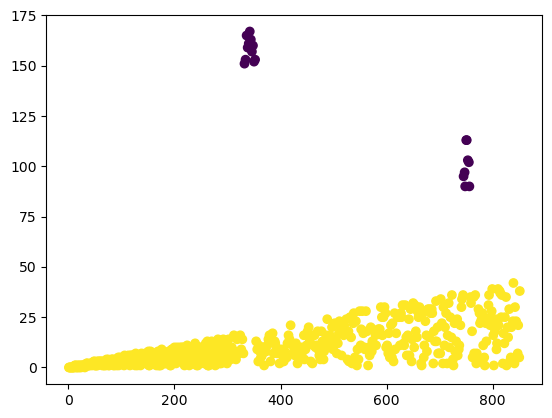

In [17]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression(C=4,solver='liblinear',penalty='l1')

# Fit the model to the training data
model.fit(X, y)

# Make predictions on the test data
predictions = model.predict(X)

plt.scatter(df['Total Volume'], df['Total Fails'], c=predictions)

Text(0.5, 1.0, 'Logistic Regression Decision Boundary')

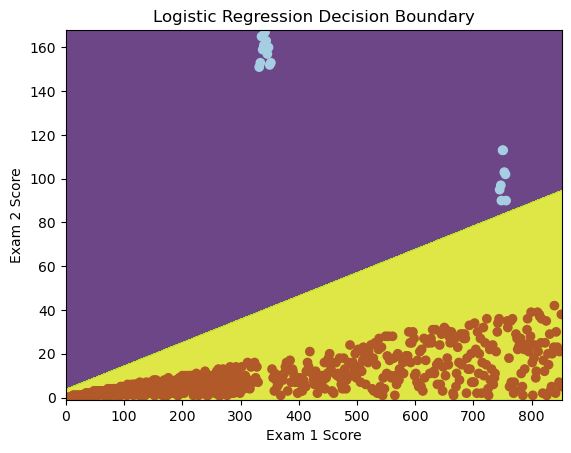

In [18]:
# Plot the decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.title('Logistic Regression Decision Boundary')

In [19]:
# Import support vector classifier
from sklearn.svm import SVC

# Create a Support Vector Classifier (SVC) model
model = SVC(kernel='linear', decision_function_shape="ovr", class_weight={1: 100000, -1: 1})  # Using a linear kernel for simplicity

# Fit the model to the training data
model.fit(X, y)

# Make predictions on the test data
predictions = model.predict(X)

# print parameters
print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)

Coefficients:  [[ 0.00184582 -0.03845458]]
Intercept:  [1.06612376]


In [20]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
print(x_min,x_max)

0 852


In [21]:
x_range = np.arange(20, 100, 1)
y_calc = -(model.coef_[0][0] / model.coef_[0][1]) * x_range - model.intercept_ / model.coef_[0][1]
decision_boundary = np.array(list(zip(x_range, y_calc)))
w_new = model.coef_[0][0] / (np.sqrt(np.sum(model.coef_[0]**2)))
margin = 1/ np.sqrt(np.sum(model.coef_[0]**2))
y_lowerbound = decision_boundary - w_new*margin

x_range = X[:,0]

y_boundary = -(model.coef_[0][0] / model.coef_[0][1]) * x_range - model.intercept_ / model.coef_[0][1]

y_median_data = np.median(X[:,1])
y_median_boundary = np.median(y_boundary)
y_sub = y_median_boundary - y_median_data


diff_X = [ i[1] - i[0] if i[2]==1 else y_sub  for i in zip(X[:,1], y_boundary, predictions)]
print(len(X))
print(len(y_boundary))
print(min(diff_X))


621
621
25.996235512847733


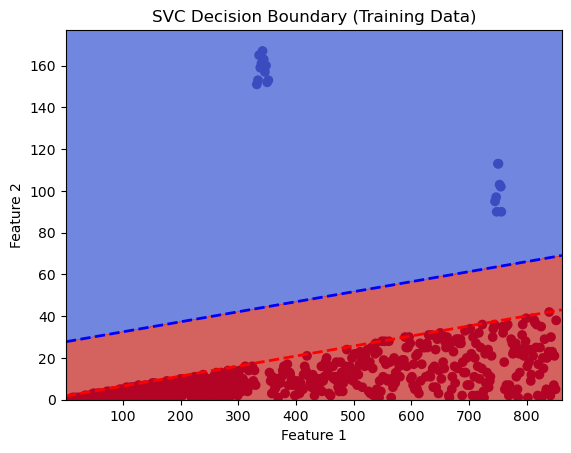

Model Coefficients:  [[ 0.00184582 -0.03845458]]
Model Intercept:  [1.06612376]
Corrected Intercept:  [27.72423551]
Corrected Intercept with Adjustment:  [1.728]

Minimum Alarms per 30 minutes before Alert can Occur:  1.728
Minimum Fraction Successful per 30 minutes before Alert can Occur:  0.952


In [24]:
# Plot the decision boundary
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    x_range = np.arange(x_min, x_max+10, h)
    y_range = np.arange(y_min, y_max+10, h)

    xx, yy = np.meshgrid(x_range,y_range )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # calc main boundary using original X values
    x_range_max = X[:,0]
    y_boundary = -(model.coef_[0][0] / model.coef_[0][1]) * x_range_max - model.intercept_ / model.coef_[0][1]
    # find difference between y of boundary and y of data
    diff_y = [ i[1] - i[0] if i[2]==1 else 1000 for i in zip(X[:,1], y_boundary, predictions)]
    # find smallest difference
    least_separation = min(diff_y)
  
    # calc lower boundary using evenly spaced X valeus
    y_calc = -(model.coef_[0][0] / model.coef_[0][1]) * x_range - model.intercept_ / model.coef_[0][1]
    decision_boundary = np.array(list(zip(x_range, y_calc)))

    # # method one - calculate lowerbounds  
    # w_new = model.coef_[0][0] / (np.sqrt(np.sum(model.coef_[0]**2)))
    # margin = least_separation/ np.sqrt(np.sum(model.coef_[0]**2))
    # y_lowerbound = decision_boundary - w_new*margin

    # # method two - calculate lowerbounds    
    y_lowerbound = decision_boundary 

    plt.plot(decision_boundary[:,0], decision_boundary[:,1] - least_separation, 'r--', linewidth=2)
    plt.plot(y_lowerbound[:,0], y_lowerbound[:,1], 'b--', linewidth=2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

    print('Model Coefficients: ', model.coef_)
    print('Model Intercept: ', model.intercept_)
    print('Corrected Intercept: ', -(model.intercept_/model.coef_[0][1]) )
    print('Corrected Intercept with Adjustment: ', -(model.intercept_/model.coef_[0][1]) - least_separation)

    print()
    print('Minimum Alarms per 30 minutes before Alert can Occur: ', round((-(model.intercept_/model.coef_[0][1]) - least_separation)[0],3) )
    print('Minimum Fraction Successful per 30 minutes before Alert can Occur: ', round(1 - ( -1 * model.coef_[0][0] / model.coef_[0][1]),3) )

plot_decision_boundary(X, y, model, 'SVC Decision Boundary (Training Data)')

In [39]:
# Naive-Bayes 
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
# Fit the model to the training data
model.fit(X, y)

# Make predictions on the test data
predictions = model.predict(X)

# Make predictions on the test data
predictions = model.predict(X)

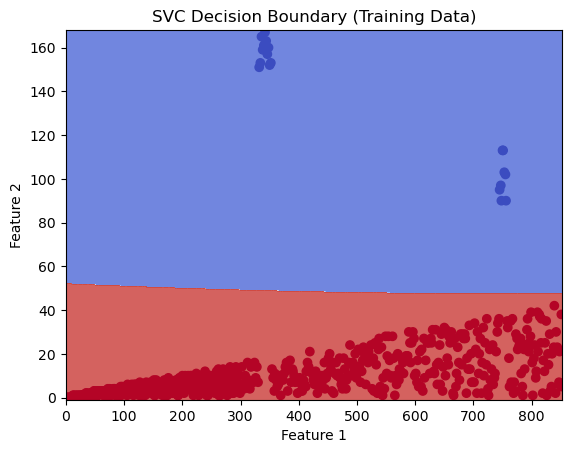

In [40]:
# Plot the decision boundary
def plot_decision_boundary(X, y, model, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

plot_decision_boundary(X, y, model, 'Gaussian Decision Boundary (Training Data)')